## Import required libraries

In [1]:
import os
import sys
import onnx
import onnxruntime
from onnx import numpy_helper
from tempfile import TemporaryDirectory

ood_path = os.path.abspath('../')
if ood_path not in sys.path:
    sys.path.append(ood_path)
    
from ood_enabler.ood_enabler import OODEnabler
from ood_enabler.model_wrapper.onnx import ONNXWrapper
from ood_enabler.storage.model_store import ModelStore
from ood_enabler.storage.local_storage import FileSystemStorage
from ood_enabler.data.pytorch_image_data_handler import PytorchImageDataHandler


# Create Model Store connection to local filesystem

In [2]:
model_store = ModelStore.from_filesystem()

## Load pretrained ResNet50 model from tf and save locally.*
### *(demo purposes only)

## Download resnet50 model from here: https://github.com/onnx/models/blob/main/vision/classification/resnet/model/resnet50-v2-12.onnx


## Then reload into memory using FileStorage

In [3]:
# Load the ResNet ONNX model
model_path = 'resnet50-v1-12.onnx'
#model = onnx.load(model_path)

model_metadata = {'type': 'onnx', 'arch': 'resnet50'} #currently no effect as only resnet50 is assumed

#with TemporaryDirectory() as tmpdir:
#    model_path = os.path.join(tmpdir, 'onnx_resnet50')
#    onnx.save(model, model_path)
    
model_wrapper = model_store.load(model_metadata, model_path)

# Enable model with OOD layer

In [5]:
onnx_model = OODEnabler.ood_enable(model_wrapper)


In [7]:
onnx_model.model.graph.output

[name: "original_output"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "N"
      }
      dim {
        dim_value: 1000
      }
    }
  }
}
, name: "log_sum_exp_output"
type {
  tensor_type {
    elem_type: 1
  }
}
]

## Run `predict` on OOD model to review change in outputs

[array([[    -2.0201,     -1.3423,     -3.6774,     -1.9188,     -2.6159,     -1.0434,      -2.744,     -1.7997,    -0.43915,     0.13979,      1.2515,     -1.5704,    -0.51589,     -2.3535,     -1.6698,    -0.27356,     -1.6596,     -1.2241,     -1.8029,     -3.4595,     -0.5272,     0.90448,    -0.36388,
           -0.62364,       3.166,    -0.78387,   -0.072938,    -0.24059,     -2.1576,     -1.8393,    0.088428,    -0.91826,   -0.056202,     -2.7152,    -0.82711,     0.77465,      1.0227,    -0.13914,     0.83138,     0.76807,     -1.1718,      2.4013,    -0.18348,     0.59977,      1.5064,    -0.62103,
            0.10314,     0.65433,    -0.17693,    -0.11911,    -0.74775,     0.26611,    -0.48118,    -0.48173,     0.61588,     -1.5732,    -0.94165,    -0.60042,    -0.38425,     0.65794,      1.5506,    -0.64162,     0.35061,      1.0082,     -1.2197,     -2.3782,      2.4565,     0.91008,      1.4765,
            0.68616,     0.30619,    -0.43578,     0.33422,     0.69102,     0

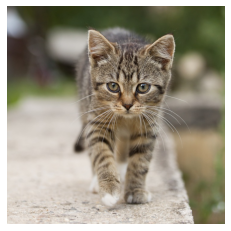

In [8]:
import onnxruntime as ort
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

session = ort.InferenceSession(onnx_model.model.SerializeToString())
  
def get_image(path, show=False):
    with Image.open(path) as img:
        img = np.array(img.convert('RGB'))
    if show:
        plt.imshow(img)
        plt.axis('off')
    return img

def preprocess(img):
    img = img / 255.
    img = cv2.resize(img, (256, 256))
    h, w = img.shape[0], img.shape[1]
    y0 = (h - 224) // 2
    x0 = (w - 224) // 2
    img = img[y0 : y0+224, x0 : x0+224, :]
    img = (img - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
    img = np.transpose(img, axes=[2, 0, 1])
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis=0)
    return img

def predict(path):
    img = get_image(path, show=True)
    img = preprocess(img)
    ort_inputs = {session.get_inputs()[0].name: img}
    #preds = session.run(None, ort_inputs)[0]
    preds = session.run(None, ort_inputs)
    return preds
    preds = np.squeeze(preds)
    a = np.argsort(preds)[::-1]
    print('class=%s ; probability=%f' %(labels[a[0]],preds[a[0]]))
    return a, preds

# Enter path to the inference image below
img_path = 'kitten.jpg'
p = predict(img_path)
#print(sum(p), a[0], p[a[0]])
print(p)